# Benchmarks for Learning Rate 0.05 and 10 Epochs of Gate Layer Training

This notebook evaluates the performance of various models trained with a gate layer using a learning rate of 0.05 and 10 epochs. The benchmarks include metrics such as:

- **Log-Loss**: Measures the error in probabilistic predictions.
- **Accuracy**: Proportion of correct predictions.
- **F1 Score**: Harmonic mean of precision and recall.
- **Precision**: Proportion of true positives among predicted positives.
- **Recall**: Proportion of true positives among actual positives.
- **AUC (Area Under Curve)**: Measures the ability of the model to distinguish between classes.
- **Inference Time**: Time taken for predictions.

The results are saved in the file `benchmarks_lr0.05_ep10.csv` located in the directory `../metric_logs`. Visualizations and summary statistics are provided to analyze the performance of different models.

In [1]:
# ────────────────────────────────────────────────────────────────
# 05_benchmarks.ipynb  ·  Final MoE test evaluation w/ pure raw‐logging
# ────────────────────────────────────────────────────────────────
%run setup.py
import time, gc, re
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from sklearn.metrics import (
    log_loss, accuracy_score, f1_score,
    precision_score, recall_score, roc_auc_score
)
from src.pretrained_models import MoEClassifier
from src.logs import log_event, LogKind

# ────────────────────────────── CONFIG ───────────────────────────────
GATE_DIR = Path("../models/gates/lr0.05_ep10")
LOGDIR   = Path("../metric_logs"); LOGDIR.mkdir(exist_ok=True)
LOG_FP   = LOGDIR / f"benchmarks_{GATE_DIR.name}.csv"
DEVICE   = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─────────────────────── parse already‐done subsets ─────────────────────
# We'll treat every line starting with a timestamp and containing "model=<key>"
# as a completed run, and skip those keys on this pass.
done = set()
_TS = re.compile(r"^\d{4}-\d{2}-\d{2}")
_MODEL = re.compile(r"model=([^,]+)")
if LOG_FP.exists():
    with LOG_FP.open("r", encoding="utf8") as f:
        for line in f:
            if _TS.match(line):
                m = _MODEL.search(line)
                if m:
                    done.add(m.group(1))

print(f"Found {len(done)} previously‐logged subsets.")

# ─────────────────────── discover which to run ─────────────────────────
suffix   = f"_idxs_{GATE_DIR.name}"
idx_files = sorted(p for p in GATE_DIR.glob("moe_*.npy") if p.stem.endswith(suffix))
runs = []
for idx_path in idx_files:
    key       = idx_path.stem.removeprefix("moe_").removesuffix(suffix)
    gate_path = GATE_DIR / f"gate_{key}_retrained.pt"
    if gate_path.exists() and key not in done:
        runs.append((key, idx_path, gate_path))

if not runs:
    print(" All subsets already evaluated — nothing to do.")
    raise SystemExit

print(f"{len(runs)} subsets to evaluate:")
for k,_,_ in runs:
    print("  •", k)

# ─────────────────────────── prepare test split ─────────────────────────
test_df    = pd.read_csv("../data/splits/test.csv")\
                   .dropna(subset=["question1","question2"])
pairs_test = list(zip(test_df.question1, test_df.question2))
y_test     = test_df.is_duplicate.values.astype(int)

# ───────────────────────── expert factories ─────────────────────────────
from src.pretrained_models import (
    BertExpert, RobertaExpert, XLNetExpert,
    QuoraDistilExpert, CrossEncExpert
)
from src.custom_models import (
    LRFeatureExpert, XGBFeatureExpert, LGBMFeatureExpert,
    KNNFeatureExpert, RFFeatureExpert, SVMFeatureExpert
)
factories = {
    "BertExpert":         BertExpert,
    "RobertaExpert":      RobertaExpert,
    "XLNetExpert":        XLNetExpert,
    "QuoraDistilExpert":  lambda: QuoraDistilExpert(
                              emb_path="../data/processed/question_embeddings_768.npy",
                              lr_path="../models/pretrained/quoradistil_lr.pkl"
                          ),
    "CrossEncExpert":     CrossEncExpert,
    "LRFeatureExpert":    lambda: LRFeatureExpert(dim=384),
    "XGBFeatureExpert":   lambda: XGBFeatureExpert(dim=384),
    "LGBMFeatureExpert":  lambda: LGBMFeatureExpert(dim=384),
    "KNNFeatureExpert":   lambda: KNNFeatureExpert(dim=384),
    "RFFeatureExpert":    lambda: RFFeatureExpert(dim=384),
    "SVMFeatureExpert":   lambda: SVMFeatureExpert(dim=384),
}

torch.cuda.empty_cache(); gc.collect()

# ───────────────────────────── evaluation ────────────────────────────────
for key, idx_path, gate_path in runs:
    torch.cuda.empty_cache(); gc.collect()
    print(f"\n=== Evaluating `{key}` ===")

    # load only needed experts
    experts = [factories[n]() for n in key.split("+")]

    # build & load gate onto GPU
    moe = MoEClassifier(experts, lr=1.0, epochs=0)
    moe.gate.to(DEVICE)
    moe.gate.load_state_dict(torch.load(gate_path, map_location=DEVICE))
    moe.gate.eval()

    # inference + metrics
    t0    = time.time()
    probs = moe.predict_prob(pairs_test)
    dt    = time.time() - t0

    preds = (probs > 0.5).astype(int)
    ll    = log_loss(y_test, probs)
    acc   = accuracy_score(y_test, preds)
    f1    = f1_score(y_test, preds)
    prec  = precision_score(y_test, preds)
    rec    = recall_score(y_test, preds)
    try:   auc = roc_auc_score(y_test, probs)
    except: auc = float("nan")

    print(f"  LL={ll:.4f}  ACC={acc:.4f}  F1={f1:.4f}  AUC={auc:.4f}  time={dt:.1f}s")

    # append _only_ raw log_event line to your benchmarks_<folder>.csv
    log_event(
        LogKind.TEST,
        folder=GATE_DIR.name,
        model=key,
        phase="eval",
        seconds=round(dt,2),
        test_LL=round(ll,6),
        test_ACC=round(acc,4),
        test_F1=round(f1,4),
        test_PREC=round(prec,4),
        test_REC=round(rec,4),
        test_AUC=round(auc,4),
    )

    # teardown & free GPU immediately
    del moe
    for e in experts:
        if getattr(e, "_model", None) is not None:
            try: e._model.cpu()
            except: pass
            e._model = None
        if getattr(e, "_tokenizer", None) is not None:
            e._tokenizer = None
        del e
    torch.cuda.empty_cache(); gc.collect()

print("\n Done — all new runs logged in", LOG_FP)

Found 0 previously‐logged subsets.
10 subsets to evaluate:
  • BertExpert+RobertaExpert+CrossEncExpert+LRFeatureExpert+SVMFeatureExpert
  • BertExpert+RobertaExpert+CrossEncExpert+LRFeatureExpert+XGBFeatureExpert
  • BertExpert+RobertaExpert+CrossEncExpert+LRFeatureExpert
  • BertExpert+RobertaExpert+CrossEncExpert+SVMFeatureExpert
  • BertExpert+RobertaExpert+QuoraDistilExpert+CrossEncExpert+LGBMFeatureExpert+SVMFeatureExpert
  • BertExpert+RobertaExpert+QuoraDistilExpert+CrossEncExpert+SVMFeatureExpert
  • BertExpert+RobertaExpert+QuoraDistilExpert+CrossEncExpert+XGBFeatureExpert+LGBMFeatureExpert
  • BertExpert+RobertaExpert+QuoraDistilExpert+CrossEncExpert+XGBFeatureExpert+SVMFeatureExpert
  • BertExpert+RobertaExpert+QuoraDistilExpert+CrossEncExpert+XGBFeatureExpert
  • BertExpert+RobertaExpert+QuoraDistilExpert+CrossEncExpert

=== Evaluating `BertExpert+RobertaExpert+CrossEncExpert+LRFeatureExpert+SVMFeatureExpert` ===
  LL=0.0383  ACC=0.9901  F1=0.9868  AUC=0.9983  time=393.5s



/home/lazar/.venvs/data-science/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  LL=0.0391  ACC=0.9902  F1=0.9869  AUC=0.9982  time=400.6s

=== Evaluating `BertExpert+RobertaExpert+QuoraDistilExpert+CrossEncExpert+SVMFeatureExpert` ===
  LL=0.0381  ACC=0.9901  F1=0.9868  AUC=0.9982  time=313.2s

=== Evaluating `BertExpert+RobertaExpert+QuoraDistilExpert+CrossEncExpert+XGBFeatureExpert+LGBMFeatureExpert` ===


/home/lazar/.venvs/data-science/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  LL=0.0382  ACC=0.9902  F1=0.9868  AUC=0.9983  time=393.9s

=== Evaluating `BertExpert+RobertaExpert+QuoraDistilExpert+CrossEncExpert+XGBFeatureExpert+SVMFeatureExpert` ===
  LL=0.0384  ACC=0.9901  F1=0.9868  AUC=0.9983  time=394.9s

=== Evaluating `BertExpert+RobertaExpert+QuoraDistilExpert+CrossEncExpert+XGBFeatureExpert` ===
  LL=0.0381  ACC=0.9901  F1=0.9868  AUC=0.9982  time=311.8s

=== Evaluating `BertExpert+RobertaExpert+QuoraDistilExpert+CrossEncExpert` ===
  LL=0.0381  ACC=0.9901  F1=0.9868  AUC=0.9983  time=222.9s

 Done — all new runs logged in ../metric_logs/benchmarks_lr0.05_ep10.csv


          seconds    test_LL   test_ACC    test_F1  test_PREC   test_REC  \
count   10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean   342.706000   0.038282   0.990120   0.986810   0.983810   0.989810   
std     60.634319   0.000305   0.000042   0.000032   0.000032   0.000032   
min    222.900000   0.038053   0.990100   0.986800   0.983800   0.989800   
25%    305.200000   0.038081   0.990100   0.986800   0.983800   0.989800   
50%    352.325000   0.038170   0.990100   0.986800   0.983800   0.989800   
75%    393.772500   0.038367   0.990100   0.986800   0.983800   0.989800   
max    400.650000   0.039055   0.990200   0.986900   0.983900   0.989900   

        test_AUC  
count  10.000000  
mean    0.998270  
std     0.000048  
min     0.998200  
25%     0.998225  
50%     0.998300  
75%     0.998300  
max     0.998300  


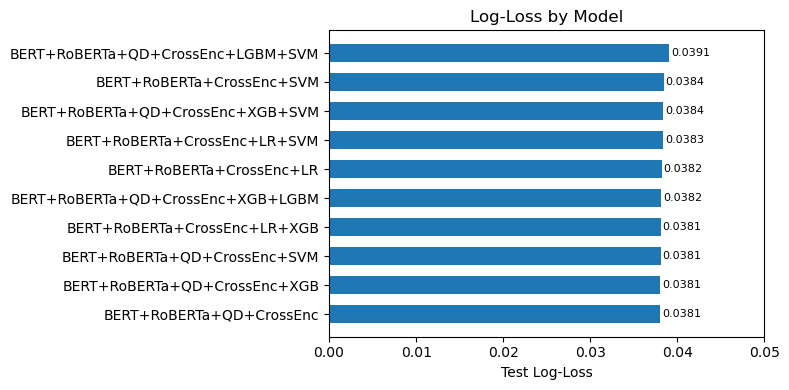

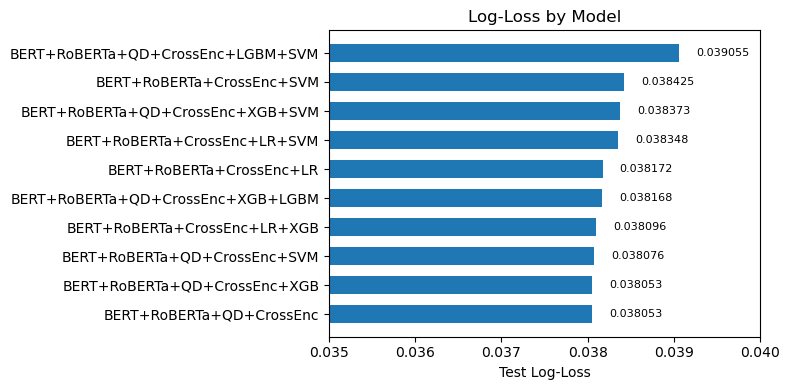

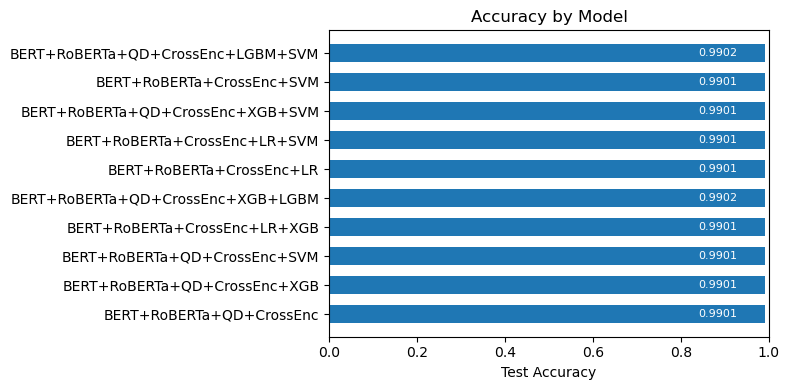

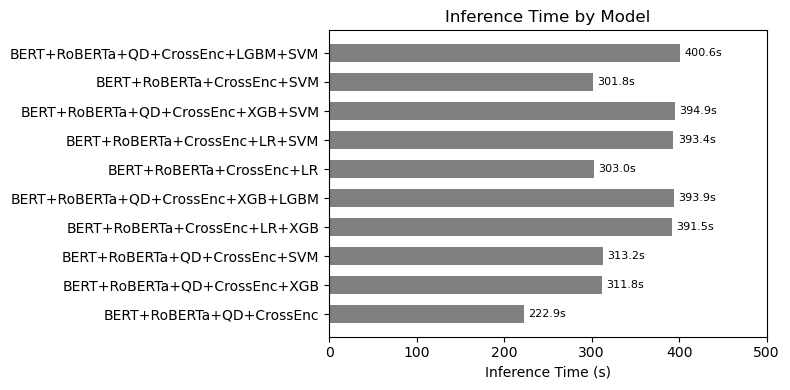

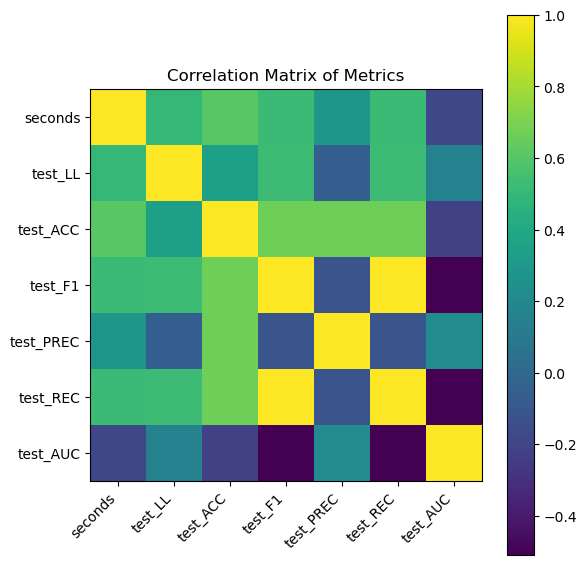

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ─────────────────────────────────────────────────────────────────────────────
# 1) Parse the raw log lines into a DataFrame
# ─────────────────────────────────────────────────────────────────────────────
records = []
with open("../metric_logs/benchmarks_lr0.05_ep10.csv", "r", encoding="utf8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split(",")
        rec = {}
        # timestamp, caller
        rec["timestamp"] = parts[0]
        rec["caller"]    = parts[1].strip("<>")
        # remaining k=v
        for kv in parts[2:]:
            if "=" not in kv:
                continue
            k, v = kv.split("=", 1)
            if k in {"seconds","test_LL","test_ACC","test_F1","test_PREC","test_REC","test_AUC"}:
                rec[k] = float(v)
            else:
                rec[k] = v
        records.append(rec)

df = pd.DataFrame(records).dropna(subset=["model","test_LL","test_ACC"])

# ─────────────────────────────────────────────────────────────────────────────
# 2) Shorten model names
# ─────────────────────────────────────────────────────────────────────────────
abbr = {
    "BertExpert":        "BERT",
    "RobertaExpert":     "RoBERTa",
    "XLNetExpert":       "XLNet",
    "QuoraDistilExpert": "QD",
    "CrossEncExpert":    "CrossEnc",
    "LRFeatureExpert":   "LR",
    "XGBFeatureExpert":  "XGB",
    "LGBMFeatureExpert": "LGBM",
    "KNNFeatureExpert":  "KNN",
    "RFFeatureExpert":   "RF",
    "SVMFeatureExpert":  "SVM",
}
def short(name):
    return "+".join(abbr.get(p,p) for p in name.split("+"))

df["short"] = df["model"].apply(short)
df = df.sort_values("test_LL").reset_index(drop=True)

# ─────────────────────────────────────────────────────────────────────────────
# 3) Summary statistics
# ─────────────────────────────────────────────────────────────────────────────
print(df[["seconds","test_LL","test_ACC","test_F1","test_PREC","test_REC","test_AUC"]]
      .describe())

# ─────────────────────────────────────────────────────────────────────────────
# 4) Bar chart: Test Log-Loss by Model
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(8, 4))
y = np.arange(len(df))
plt.barh(y, df["test_LL"], height=0.6)
plt.yticks(y, df["short"])
plt.xlabel("Test Log-Loss")
plt.title("Log-Loss by Model")
plt.xlim(0, 0.05)
# annotate
for i, v in enumerate(df["test_LL"]):
    plt.text(v + 0.0002, i, f"{v:.4f}", va="center", fontsize=8)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
y = np.arange(len(df))
plt.barh(y, df["test_LL"], height=0.6)
plt.yticks(y, df["short"])
plt.xlabel("Test Log-Loss")
plt.title("Log-Loss by Model")
plt.xlim(0.035, 0.040)
# annotate
for i, v in enumerate(df["test_LL"]):
    plt.text(v + 0.0002, i, f"{v:.6f}", va="center", fontsize=8)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# 5) Bar chart: Test Accuracy by Model
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(8, 4))
plt.barh(y, df["test_ACC"], height=0.6)
plt.yticks(y, df["short"])
plt.xlabel("Test Accuracy")
plt.title("Accuracy by Model")
plt.xlim(0, 1.00)
for i, v in enumerate(df["test_ACC"]):
    plt.text(v - 0.15, i, f"{v:.4f}", va="center", fontsize=8, color="white")
plt.tight_layout()
plt.show()

# plt.figure(figsize=(8, 4))
# plt.barh(y, df["test_ACC"], height=0.6)
# plt.yticks(y, df["short"])
# plt.xlabel("Test Accuracy")
# plt.title("Accuracy by Model")
# plt.xlim(0.9, 1.00)
# for i, v in enumerate(df["test_ACC"]):
#     plt.text(v - 0.015, i, f"{v:.4f}", va="center", fontsize=8, color="white")
# plt.tight_layout()
# plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# 6) Bar chart: Inference Time by Model
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(8, 4))
plt.barh(y, df["seconds"], height=0.6, color="gray")
plt.yticks(y, df["short"])
plt.xlabel("Inference Time (s)")
plt.title("Inference Time by Model")
plt.xlim(0, 500)
for i, v in enumerate(df["seconds"]):
    plt.text(v + 5, i, f"{v:.1f}s", va="center", fontsize=8)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# 7) Correlation matrix heatmap
# ─────────────────────────────────────────────────────────────────────────────
metrics = ["seconds","test_LL","test_ACC","test_F1","test_PREC","test_REC","test_AUC"]
corr = df[metrics].corr("spearman")
plt.figure(figsize=(6, 6))
plt.imshow(corr, cmap="viridis", interpolation="none")
plt.colorbar()
plt.xticks(range(len(metrics)), metrics, rotation=45, ha="right")
plt.yticks(range(len(metrics)), metrics)
plt.title("Correlation Matrix of Metrics")
plt.tight_layout()
plt.show()

In [9]:
# ─────────────────────────────────────────────────────────────────────────────
# 1) Sort the DataFrame so our “best” models come first:
#    • Primary key: lowest log-loss (ascending)
#    • Secondary key: highest accuracy (descending)
#    • Tertiary key: highest F1 (descending)
# ─────────────────────────────────────────────────────────────────────────────
df = (
    df
    .sort_values(
        by=["test_LL", "test_ACC", "test_F1"],
        ascending=[True, False, False]  # True→low better; False→high better
    )
    .reset_index(drop=True)  # reset index after sorting
)


# ─────────────────────────────────────────────────────────────────────────────
# 2) Build a clean, publication-ready table of metrics
# ─────────────────────────────────────────────────────────────────────────────

# Columns in the order we want them to appear in the final output
pretty_cols = [
    "short",       # human-friendly model name
    "test_LL",     # log-loss
    "test_ACC",    # accuracy
    "test_F1",     # F1 score
    "test_PREC",   # precision
    "test_REC",    # recall
    "test_AUC",    # ROC-AUC
    "seconds"      # inference time
]

# 2a) Slice + rename + format numerical precision
table_df = (
    df[pretty_cols]
      .rename(columns={
          "short":       "Model",
          "test_LL":     "Log-Loss",
          "test_ACC":    "Accuracy",
          "test_F1":     "F1",
          "test_PREC":   "Precision",
          "test_REC":    "Recall",
          "test_AUC":    "ROC-AUC",
          "seconds":     "Inference Time (s)",
      })
      .assign(
          **{
              "Log-Loss":           lambda d: d["Log-Loss"].map("{:.6f}".format),
              "Accuracy":           lambda d: d["Accuracy"].map("{:.4f}".format),
              "F1":                 lambda d: d["F1"].map("{:.4f}".format),
              "Precision":          lambda d: d["Precision"].map("{:.4f}".format),
              "Recall":             lambda d: d["Recall"].map("{:.4f}".format),
              "ROC-AUC":            lambda d: d["ROC-AUC"].map("{:.4f}".format),
              "Inference Time (s)": lambda d: d["Inference Time (s)"].map("{:.2f}".format),
          }
      )
)

# ─────────────────────────────────────────────────────────────────────────────
# 2b) Render as a Markdown table for easy embedding in reports/notebooks
# ─────────────────────────────────────────────────────────────────────────────
import tabulate

md_table = tabulate.tabulate(
    table_df.values,
    headers=table_df.columns,
    tablefmt="github",
    stralign="center"
)
print(md_table)


# ─────────────────────────────────────────────────────────────────────────────
# 2c) (Optional) Save the same table as a PNG for inclusion in a paper
#         – uncomment the block below if you need an image file
# ─────────────────────────────────────────────────────────────────────────────
# import matplotlib.pyplot as plt
#
# fig, ax = plt.subplots(figsize=(12, 0.6 + 0.3 * len(table_df)))
# ax.axis("off")
# tbl = ax.table(
#     cellText=table_df.values,
#     colLabels=table_df.columns,
#     loc="center",
#     cellLoc="center"
# )
# tbl.auto_set_font_size(False)
# tbl.set_fontsize(9)
# tbl.scale(1, 1.5)
# plt.tight_layout()
# fig.savefig("../metric_logs/benchmark_table.png", dpi=300, bbox_inches="tight")
# plt.close(fig)
# print("Saved table image → metric_logs/benchmark_table.png")

|               Model               |   Log-Loss |   Accuracy |     F1 |   Precision |   Recall |   ROC-AUC |   Inference Time (s) |
|-----------------------------------|------------|------------|--------|-------------|----------|-----------|----------------------|
|     BERT+RoBERTa+QD+CrossEnc      |   0.038053 |     0.9901 | 0.9868 |      0.9838 |   0.9898 |    0.9983 |               222.9  |
|   BERT+RoBERTa+QD+CrossEnc+XGB    |   0.038053 |     0.9901 | 0.9868 |      0.9838 |   0.9898 |    0.9982 |               311.8  |
|   BERT+RoBERTa+QD+CrossEnc+SVM    |   0.038076 |     0.9901 | 0.9868 |      0.9838 |   0.9898 |    0.9982 |               313.18 |
|   BERT+RoBERTa+CrossEnc+LR+XGB    |   0.038096 |     0.9901 | 0.9868 |      0.9838 |   0.9898 |    0.9983 |               391.47 |
| BERT+RoBERTa+QD+CrossEnc+XGB+LGBM |   0.038168 |     0.9902 | 0.9868 |      0.9839 |   0.9898 |    0.9983 |               393.88 |
|     BERT+RoBERTa+CrossEnc+LR      |   0.038172 |     0.9901 | 0.986